In [1]:
import pandas as pd

# 1. Load RFM table
rfm = pd.read_csv("../data/processed/rfm.csv")

# 2. Quick check
print(rfm.shape)
rfm.head()


(4339, 5)


,CustomerID,InvoiceDate,Recency,Frequency,Monetary
0,12346.0,2011-01-18 10:01:00,326,1,77183.60
1,12347.0,2011-12-07 15:52:00,2,7,4310.00
2,12348.0,2011-09-25 13:13:00,75,4,1797.24
3,12349.0,2011-11-21 09:51:00,19,1,1757.55
4,12350.0,2011-02-02 16:01:00,310,1,334.40


In [2]:
from sklearn.preprocessing import StandardScaler

# 1. Select features
features = ['Recency', 'Frequency', 'Monetary']
X = rfm[features]

# 2. Initialize scaler
scaler = StandardScaler()

# 3. Fit & transform
X_scaled = scaler.fit_transform(X)

# 4. Convert back to DataFrame (optional, for clarity)
import numpy as np
X_scaled = pd.DataFrame(X_scaled, columns=features)

# 5. Preview
X_scaled.describe().round(2)


,Recency,Frequency,Monetary
count,4339.00,4339.00,4339.00
mean,0.00,0.00,-0.00
std,1.00,1.00,1.00
min,-0.92,-0.42,-0.23
25%,-0.75,-0.42,-0.19
50%,-0.42,-0.29,-0.15
75%,0.49,0.09,-0.04
max,2.81,26.70,30.95


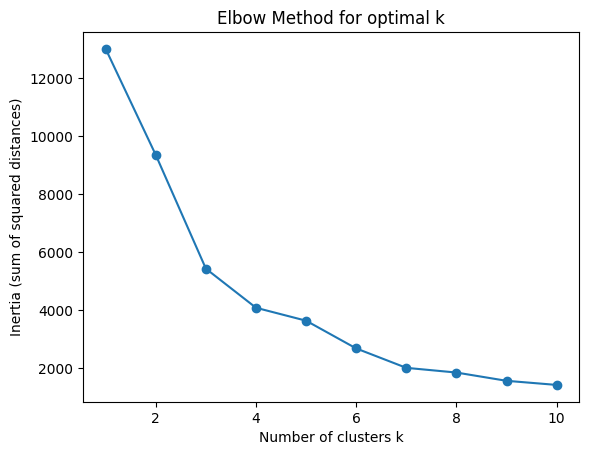

In [3]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Range of k to try
ks = range(1, 11)
inertias = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

# Plot
plt.plot(ks, inertias, marker='o')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia (sum of squared distances)')
plt.title('Elbow Method for optimal k')
plt.show()


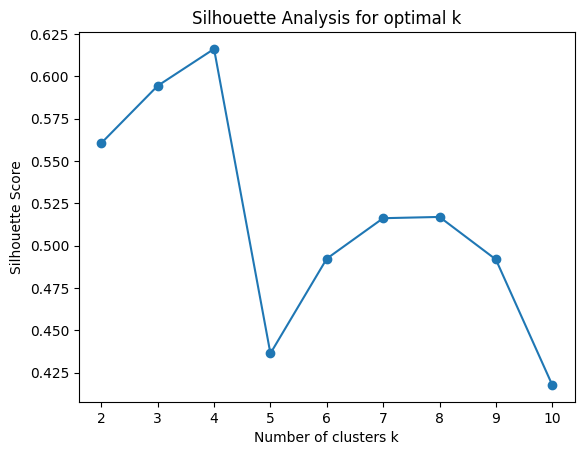

In [4]:
from sklearn.metrics import silhouette_score

scores = []
for k in ks[1:]:  # silhouette undefined for k=1
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    scores.append(silhouette_score(X_scaled, labels))

# Plot
plt.plot(ks[1:], scores, marker='o')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for optimal k')
plt.show()


In [5]:
# 1. Fit final model
final_k = 4
kmeans = KMeans(n_clusters=final_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)

# 2. Inspect cluster sizes
rfm['Cluster'].value_counts().sort_index()


Cluster
0     211
1    1062
2      13
3    3053
Name: count, dtype: int64

In [6]:
# 1. Inverse transform centroids
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroids = pd.DataFrame(centroids, columns=features)
centroids['Cluster'] = range(final_k)
centroids


,Recency,Frequency,Monetary,Cluster
0,15.603774,22.004717,12422.315802,0
1,248.661640,1.551367,478.194732,1
2,7.384615,82.692308,127338.313846,2
3,43.957746,3.652145,1347.891996,3


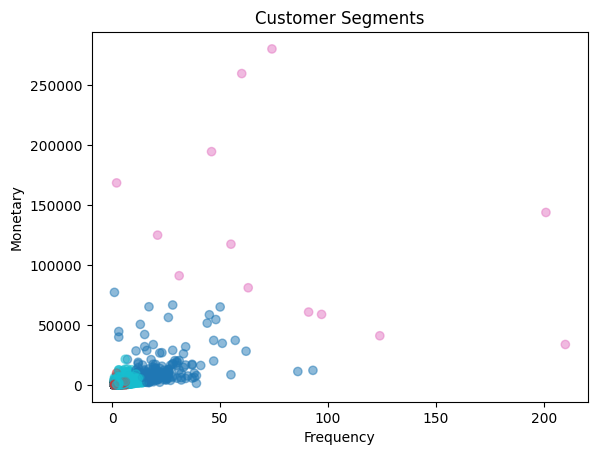

In [7]:
plt.scatter(rfm['Frequency'], rfm['Monetary'], c=rfm['Cluster'], cmap='tab10', alpha=0.5)
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('Customer Segments')
plt.show()


In [9]:
# Group by cluster and calculate mean values
cluster_profile = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean().round(1)
cluster_profile['Count'] = rfm['Cluster'].value_counts().sort_index().values
cluster_profile


,Recency,Frequency,Monetary,Count
Cluster,,,,
0,15.7,22.0,12453.2,211
1,248.6,1.6,478.1,1062
2,7.4,82.7,127338.3,13
3,43.9,3.7,1349.7,3053
